In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip
!unzip -qq -o Food-5K.zip
!ls
!ls Food-5K/training
!mv Food-5K/* .

--2021-10-29 11:43:13--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  34.5MB/s    in 13s     

2021-10-29 11:43:27 (32.2 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]

Food-5K  Food-5K.zip  __MACOSX	sample_data
0_0.jpg     0_1387.jpg	0_422.jpg  0_809.jpg   1_1195.jpg  1_230.jpg  1_617.jpg
0_1000.jpg  0_1388.jpg	0_423.jpg  0_80.jpg    1_1196.jpg  1_231.jpg  1_618.jpg
0_1001.jpg  0_1389.jpg	0_424.jpg  0_810.jpg   1_1197.jpg  1_232.jpg  1_619.jpg
0_1002.jpg  0_138.jpg	0_425.jpg  0_811.jpg   1_1198.jpg  1_233.jpg  1_61.jpg
0_1003.jpg  0_1390.jpg	0_426.jpg  0_812.jpg   1_1199.jpg  1_234.jpg  1_620.jpg
0_1004.jpg  0_1

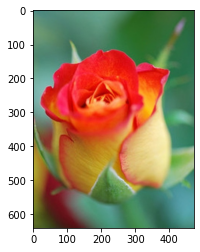

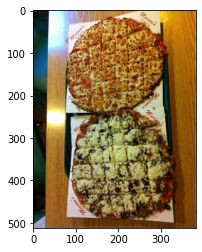

In [3]:
plt.imshow(image.load_img('training/0_808.jpg'))
plt.show()

plt.imshow(image.load_img('training/1_616.jpg'))
plt.show()

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/train’: File exists
mkdir: cannot create directory ‘data/test’: File exists
mkdir: cannot create directory ‘data/train/nonfood’: File exists
mkdir: cannot create directory ‘data/train/food’: File exists
mkdir: cannot create directory ‘data/test/nonfood’: File exists
mkdir: cannot create directory ‘data/test/food’: File exists
mv: cannot stat 'training/0*.jpg': No such file or directory
mv: cannot stat 'training/1*.jpg': No such file or directory
mv: cannot stat 'validation/0*.jpg': No such file or directory
mv: cannot stat 'validation/1*.jpg': No such file or directory


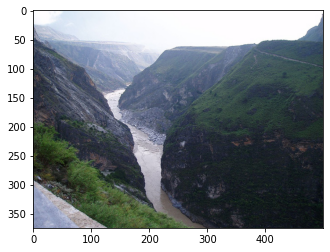

In [5]:
!mkdir data

# Make directories to store the data Keras-style
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

# Move the images
# Note: we will consider 'training' to be the train set
#       'validation' folder will be the test set
#       ignore the 'evaluation' set
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

train_path = 'data/train'
valid_path = 'data/test'

# These images are pretty big and of different sizes
# Let's load them all in as the same (smaller) size
IMAGE_SIZE = [200, 200]

# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

# useful for getting number of classes
folders = glob(train_path + '/*')
folders

# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [16]:
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=IMAGE_SIZE + [3])
vgg_model.trainable = False

In [19]:
x = Flatten()(vgg_model.output)

pt_model = Model(vgg_model.input, x)
pt_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0   

In [25]:
batch_size = 128
image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = image_generator.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

valid_generator = image_generator.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [24]:
Ntrain = len(image_files)
Nvalid = len(valid_image_files)

# Figure out the output size
feat = pt_model.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D = feat.shape[1]

In [37]:
X_train = np.zeros((Ntrain, D))
Y_train = np.zeros(Ntrain)
X_valid = np.zeros((Nvalid, D))
Y_valid = np.zeros(Nvalid)

i, j = 0, 0
for x, y in train_generator:
  current_batch_size = len(y)
  j += 1
  print('Generating', j, '-th batch scope:[', i, ',', i+current_batch_size, ']')

  features = pt_model.predict(x)
  X_train[i:i+current_batch_size] = features
  Y_train[i:i+current_batch_size] = y
  i += current_batch_size

  if i >= Ntrain:
    print('breaking now')
    break

    
i, j = 0, 0
for x, y in valid_generator:
  current_batch_size = len(y)
  j += 1
  print('Generating', j, '-th batch scope:[', i, ',', i+current_batch_size, ']')

  features = pt_model.predict(x)
  X_valid[i:i+current_batch_size] = features
  Y_valid[i:i+current_batch_size] = y
  i += current_batch_size

  if i >= Nvalid:
    print('breaking now')
    break


Generating 1 -th batch scope:[ 0 , 56 ]
Generating 2 -th batch scope:[ 56 , 184 ]
Generating 3 -th batch scope:[ 184 , 312 ]
Generating 4 -th batch scope:[ 312 , 440 ]
Generating 5 -th batch scope:[ 440 , 568 ]
Generating 6 -th batch scope:[ 568 , 696 ]
Generating 7 -th batch scope:[ 696 , 824 ]
Generating 8 -th batch scope:[ 824 , 952 ]
Generating 9 -th batch scope:[ 952 , 1080 ]
Generating 10 -th batch scope:[ 1080 , 1208 ]
Generating 11 -th batch scope:[ 1208 , 1336 ]
Generating 12 -th batch scope:[ 1336 , 1464 ]
Generating 13 -th batch scope:[ 1464 , 1592 ]
Generating 14 -th batch scope:[ 1592 , 1720 ]
Generating 15 -th batch scope:[ 1720 , 1848 ]
Generating 16 -th batch scope:[ 1848 , 1976 ]
Generating 17 -th batch scope:[ 1976 , 2104 ]
Generating 18 -th batch scope:[ 2104 , 2232 ]
Generating 19 -th batch scope:[ 2232 , 2360 ]
Generating 20 -th batch scope:[ 2360 , 2488 ]
Generating 21 -th batch scope:[ 2488 , 2616 ]
Generating 22 -th batch scope:[ 2616 , 2744 ]
Generating 23 -th 

In [40]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [43]:
# standard Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_scaled, Y_train)
print(lr.score(X_train_scaled, Y_train))
print(lr.score(X_valid_scaled, Y_valid))

1.0
0.979


In [45]:
feat.shape

(1, 18432)

In [54]:
# same using ANN
i = Input((D,))
x = Dense(1, activation='sigmoid')(i)
model = Model(i, x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=10, batch_size=batch_size)

Epoch 1/10
24/24 [==============================] - 1s 17ms/step - loss: 0.7465 - accuracy: 0.9410 - val_loss: 0.3347 - val_accuracy: 0.9750
Epoch 2/10
24/24 [==============================] - 0s 10ms/step - loss: 0.0459 - accuracy: 0.9953 - val_loss: 0.3375 - val_accuracy: 0.9750
Epoch 3/10
24/24 [==============================] - 0s 10ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.3118 - val_accuracy: 0.9760
Epoch 4/10
24/24 [==============================] - 0s 10ms/step - loss: 8.0568e-05 - accuracy: 1.0000 - val_loss: 0.3093 - val_accuracy: 0.9750
Epoch 5/10
24/24 [==============================] - 0s 10ms/step - loss: 9.7992e-06 - accuracy: 1.0000 - val_loss: 0.3089 - val_accuracy: 0.9750
Epoch 6/10
24/24 [==============================] - 0s 9ms/step - loss: 6.1046e-06 - accuracy: 1.0000 - val_loss: 0.3088 - val_accuracy: 0.9750
Epoch 7/10
24/24 [==============================] - 0s 10ms/step - loss: 4.9792e-06 - accuracy: 1.0000 - val_loss: 0.3088 - val_accuracy: 0.975

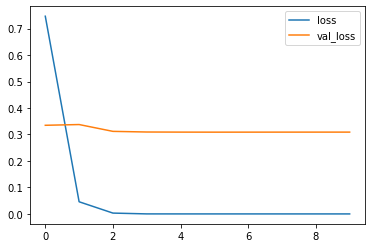

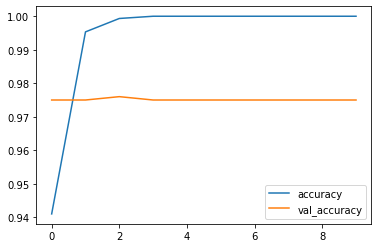

In [55]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()